In [3]:
import turbo as tb
import rul_dataframe as rd
import plots as pl
import labeling as lb
import preprocessing as pre
import classification as cls
import variational_autoencoder as vae_class

import pandas as pd
import numpy as np
import tensorflow as tf, keras
from keras import Sequential, layers, regularizers
from keras.layers import LSTM, Dense, Masking, Conv1D, Dropout
import matplotlib.pyplot as plt

In [19]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score

# Prepare Dataset

In [499]:
dataset = 2
tr, te, rl = tb.getTFDataset(set = dataset)
tb.addTFlinear(tr, te, rl)
tr_df = rd.RUL_DataFrame(df = tr, label_cols = ['linear'])
te_df = rd.RUL_DataFrame(df = te, label_cols = ['linear'])

In [6]:
#plots = pl.Plots(tr_df)
preproc = pre.Preprocessing()
classy = cls.Classification()
label = lb.Labeling()

In [501]:
if dataset in [1,3]:
    preproc.drop_zero_variance(rul_df = tr_df, rul_df_test = te_df)
    preproc.scale(rul_df = tr_df, rul_df_test = te_df, scale = 'std')
elif dataset in [2, 4]:
    classy.fit_kmeans(rul_df = tr_df, rul_df_test = te_df, colname = 'kmeans')
    preproc.one_hot_encode(rul_df = tr_df, rul_df_test = te_df, c_col = 'kmeans')
    preproc.c_drop_zero_variance(rul_df = tr_df, rul_df_test = te_df , c_cols = tr_df.categ_cols)
    preproc.c_scale(rul_df = tr_df, rul_df_test = te_df , c_cols = tr_df.categ_cols, scale = 'std')

In [502]:
# Optional smoothing
smoothing = False
if smoothing:
    preproc.moving_average(rul_df = tr_df, shift = 10, mp = 10)
    preproc.moving_average(rul_df = te_df, shift = 10, mp = 10)
else:
    # Or
    preproc.delete_first_n(tr_df, 9)

In [20]:
# prepare data functions
# 1. training-validation split
def training_validation_split(X, Y, groupshufflesplit, groups = tr_df.df[tr_df.id_col], verbose = False):
    for itrain, ival in groupshufflesplit.split(X, Y, groups = groups):
        Xtrain = X.iloc[itrain].copy()
        Ytrain = Y.iloc[itrain].copy()
        Xval = X.iloc[ival].copy()
        Yval = Y.iloc[ival].copy()
        if verbose:
            print(f'Training data ids {groups[itrain].unique()}')
            print(f'Validation data ids {groups[ival].unique()}')
    return Xtrain, Ytrain, groups[itrain], Xval, Yval, groups[ival]

# 2. make xtest
def make_xtest_to_sequence_one_id(df, sequence_length, mask_value):
    n = df.shape[0]
    if n >= sequence_length:
        yield df[(n-sequence_length):]
    if n < sequence_length:
        index = sequence_length - n
        Xpadded = np.full(shape = (sequence_length, df.shape[1]), fill_value = mask_value).astype(np.float32)
        Xpadded[index:, :] = df.values
        yield Xpadded
def make_xtest_to_sequence(df, sequence_length, groups, mask_value):
    Xtemp = (list(make_xtest_to_sequence_one_id(df[groups==i], sequence_length, mask_value)) for i in groups.unique())
    return np.concatenate(list(Xtemp)).astype(np.float32)

# 3. make ytest
def make_ytest_one_id(df, sequence_length):
    return df[-1:]   
def make_ytest(df, sequence_length, groups):
    Ytemp = [make_ytest_one_id(df[groups==i], sequence_length) for i in groups.unique()]
    return np.concatenate(Ytemp).astype(np.float32)

# 4. make xrain data
def make_data_to_sequence_one_id(df, sequence_length, mask_value, stride, y, frac):
    n = df.shape[0]
    if not stride:
        stride = int(sequence_length/2)
    counter = 0
    for start, stop in zip(range(0, n - sequence_length + 1, int(stride/frac)), range(sequence_length, n + 1, int(stride/frac))):
        if stop <= (n - 70) and counter % frac == 0:
            if y:
                yield(df.values[start:stop,:][-1])
            else:
                yield(df.values[start:stop,:])
        if stop > (n - 70):
            if y:
                yield(df.values[start:stop,:][-1])
            else:
                yield(df.values[start:stop,:])
        counter = counter + 1
def make_data_to_sequence(df, sequence_length, groups, mask_value, stride = None, y = False, frac = 1):
    if not stride % frac == 0:
        print('stride/frac!')
    Xtemp = ((list(make_data_to_sequence_one_id(df[groups==i], sequence_length, mask_value, stride, y, frac))) for i in groups.unique())
    return np.concatenate(list(Xtemp)).astype(np.float32)

# Lableing

In [503]:
labels = pd.read_csv(f'labels/FD00{dataset}')
label_cols = ['linear', 'piecewise_optimized', 'piecewies_125', 'descriptive', 'spearman', 'rec_error']
if not labels.shape[0] == tr_df.df.shape[0]:
    print(f'Labels and Data do not have same length. Dataset FD00{dataset}')

In [358]:
tr_df.df.values[0:2,:][-1]

array([ 1.00000000e+01,  1.00000000e+00,  1.10000000e+01,  4.20029000e+01,
        8.40000000e-01,  1.00000000e+02,  2.42861931e-01, -3.09416651e-01,
       -2.05911613e-01, -1.18475462e+00, -1.86828828e+00, -1.27302579e+00,
       -1.48052636e+00, -1.58300441e-01, -4.13693874e-01, -4.09512577e-01,
       -1.27518038e+00, -7.88846072e-01,  3.21075188e-01,  3.46944695e-18,
       -4.72098458e-02,  0.00000000e+00, -7.08128291e-01, -1.83793021e-01,
        1.38000000e+02,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [504]:
temp = pd.concat([tr_df.df, labels], axis=1)
training_data_with_labels = rd.RUL_DataFrame(df = temp, data_cols = tr_df.data_cols, label_cols = ['linear', 'piecewise_optimized', 'piecewise_125', 'descriptive', 'spearman',
                                                        'rec_error'])

In [505]:
Xtrain = training_data_with_labels.df[training_data_with_labels.data_cols]
Xtest = te_df.df[te_df.data_cols]

In [506]:
Ytrain = training_data_with_labels.df[training_data_with_labels.label_cols]
Ytest = te_df.df['linear']

In [563]:
sequence_length = 60
stride = 20
frac = 2 # means stride gets doubled if near death (more data)
mask_value = -100.0
groupshufflesplit = GroupShuffleSplit(n_splits = 1, train_size = 0.8 , random_state = 42)
Xtrain_split, Ytrain_split, groupstrain, Xval_split, Yval_split, groupsval = training_validation_split(Xtrain, Ytrain, groupshufflesplit, 
                                                                                    groups = training_data_with_labels.df[training_data_with_labels.id_col])

Xtrain_split_sequences = make_data_to_sequence(Xtrain_split, sequence_length, groupstrain, mask_value, stride, frac = 2)
Ytrain_split_sequences = make_data_to_sequence(Ytrain_split, sequence_length, groupstrain, mask_value, stride, y = True, frac = 2)
Xval_split_sequences = make_data_to_sequence(Xval_split, sequence_length, groupsval, mask_value, stride, frac = 2)
Yval_split_sequences = make_data_to_sequence(Yval_split, sequence_length, groupsval, mask_value, stride, y = True, frac = 2)

Xtrain_whole_sequences = make_data_to_sequence(Xtrain, sequence_length, tr_df.df[tr_df.id_col], mask_value, stride, frac = 2)
Ytrain_whole_sequences = make_data_to_sequence(Ytrain, sequence_length, tr_df.df[tr_df.id_col], mask_value, stride, y = True, frac = 2)

Xtest_sequences = make_xtest_to_sequence(Xtest, sequence_length, te_df.df[te_df.id_col], mask_value)
Ytest_sequences = make_ytest(Ytest, sequence_length, te_df.df[te_df.id_col])

278
(60, 14)
278
(60, 14)
278
(60, 14)
170
(60, 14)
170
(60, 14)
170
(60, 14)
180
(60, 14)
180
(60, 14)
180
(60, 14)
180
(54, 14)
179
(60, 14)
179
(60, 14)
179
(60, 14)
250
(60, 14)
250
(60, 14)
250
(60, 14)
141
(60, 14)
141
(60, 14)
141
(60, 14)
141
(55, 14)
192
(60, 14)
192
(60, 14)
192
(60, 14)
213
(60, 14)
213
(60, 14)
213
(60, 14)
161
(60, 14)
161
(60, 14)
161
(60, 14)
161
(55, 14)
171
(60, 14)
171
(60, 14)
171
(60, 14)
198
(60, 14)
198
(60, 14)
198
(60, 14)
200
(60, 14)
200
(60, 14)
200
(60, 14)
200
(54, 14)
267
(60, 14)
267
(60, 14)
267
(60, 14)
267
(60, 14)
186
(60, 14)
186
(60, 14)
186
(60, 14)
186
(60, 14)
225
(60, 14)
225
(60, 14)
225
(60, 14)
225
(59, 14)
186
(60, 14)
186
(60, 14)
186
(60, 14)
186
(60, 14)
193
(60, 14)
193
(60, 14)
193
(60, 14)
138
(60, 14)
138
(60, 14)
138
(60, 14)
221
(60, 14)
221
(60, 14)
221
(60, 14)
221
(55, 14)
190
(60, 14)
190
(60, 14)
190
(60, 14)
147
(60, 14)
147
(60, 14)
147
(60, 14)
147
(60, 14)
156
(60, 14)
156
(60, 14)
156
(60, 14)
154
(60, 14)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 1 dimension(s)

In [508]:
Xtrain_split_sequences.shape

(1561, 60, 18)

In [510]:
Ytrain_split_sequences[:,0].shape

(1561,)

In [511]:
Xval_split_sequences.shape

(361, 60, 18)

In [512]:
Yval_split_sequences.shape

(361, 6)

In [272]:
Ytest_sequences.shape

(100,)

# Scoring

In [24]:
def s_score(Y, Yhat, a1 = 10, a2 = 13):
    s = 0.0
    for i in range(len(Y)):
        d = Yhat[i] - Y[i]
        if d < 0:
            s = s + np.exp(-d/a1) - 1
        else:
            s = s + np.exp(d/a2) - 1
    return s

def l_score(Y, Yhat):
    s = 0.0
    for i in range(len(Y)):
        d = (Yhat[i] - Y[i])**2
        if Y[i] < 50:
            s = s + 2 * d
        else:
            s = s + 0.5 * d
    return s/len(Y)

def evaluate(Y, Yhat, label = 'Test'):
    if label == 'Test':
        rsme = np.sqrt(mean_squared_error(Y, Yhat))
        r2 = r2_score(Y, Yhat)
        s = s_score(Y, Yhat)
        l = l_score(Y, Yhat)
        if type(s) == np.ndarray:
            s = s[0]
        if type(l) == np.ndarray:
            l = l[0]
        print(f'{label} set RSME = {rsme}, S = {s}, L= {l}, R2 = {r2}')
        return rsme, s, l, r2
    else:
        rsme = np.sqrt(mean_squared_error(Y.flatten(), Yhat.flatten()))
        r2 = r2_score(Y.flatten(), Yhat.flatten())
        print(f'{label} set RSME = {rsme}, R2 = {r2}')
        return rsme, r2

In [147]:
Ytrain_whole_sequences[:,:,0].flatten().shape

(741550,)

In [141]:
mean_squared_error(Ytrain_whole_sequences[0,:,0], Yhat_train[0,:])

235.39552

# Train LSTM

In [22]:
def make_model(input_shape = Xtrain_split_sequences.shape[1:], masking = True, mask_value = -100., conv_layer = True, n_channels = 32, kernel_size = 5,
                dense_regulatization = regularizers.l2(0.001), lstm_regularization = regularizers.l2(0.001), conv_regualrizer = regularizers.l2(0.001),
                lstm_dims = [128, 96], dropout = True, d_rate = 0.2, dense_dims =  [48, 16]):
    model = Sequential()
    if masking:
        model.add(Masking(mask_value = mask_value, input_shape = input_shape))
    if conv_layer:
        model.add(Conv1D(filters = n_channels, kernel_size = kernel_size, activation = 'relu', kernel_regularizer = conv_regualrizer, padding = 'same'))
        if dropout:
            model.add(Dropout(rate = d_rate))
    n = len(lstm_dims)
    c = 0
    rs = True
    for d in lstm_dims:
        c = c + 1
        if c == n:
            rs = False
        model.add(LSTM(units = d, return_sequences = rs, kernel_regularizer = lstm_regularization))
        if dropout:
            model.add(Dropout(rate = d_rate))
    for d in dense_dims:
        model.add(Dense(units = d, activation = 'relu', kernel_regularizer = dense_regulatization))
        if dropout:
            model.add(Dropout(rate = d_rate))
    model.add(Dense(units = 1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [524]:
path = f'scores/LSTM_FD00{dataset}'
results = pd.DataFrame(columns=['dataset', 'label', 'RSME','R2','RSME','S Score', 'L Score', 'R2'])
predictions = []
predictions_test = []
for l in range(1): #'linear', 'piecewise_optimized', 'piecewise_125', 'descriptive', 'spearman', 'rec_error'
    keras.backend.clear_session()
    lstm_model = make_model(input_shape = Xtrain_split_sequences.shape[1:], masking = True, mask_value = -100., conv_layer = True, n_channels = 32, kernel_size = 10,
                regularization = regularizers.l2(0.001),
                lstm_dims = [256], dropout = True, d_rate = 0.2, dense_dims =  [16])
    lstm_model.fit(Xtrain_split_sequences, Ytrain_split_sequences[:,l],
                    validation_data = (Xval_split_sequences, Yval_split_sequences[:,l]),
                    epochs = 20,
                    batch_size = 32) 
    label_name = label_cols[l]
    # lstm_model.save(f'saved_models/lstm_model_FD00{dataset}_{label_name}')
    Yhat_train = lstm_model.predict(Xtrain_whole_sequences)
    predictions.append(Yhat_train)
    rsme1, r21 = evaluate(Ytrain_whole_sequences[:,l], Yhat_train, 'Train')
    Yhat_test = lstm_model.predict(Xtest_sequences)
    predictions_test.append(Yhat_test)
    rsme2, s, ls, r22 = evaluate(Ytest_sequences, Yhat_test)
    df = pd.DataFrame([[dataset, label_name, rsme1, r21, rsme2, s, ls, r22]], columns=['dataset', 'label', 'RSME','R2','RSME','S Score', 'L Score', 'R2'])
    results = pd.concat((results, df))
results.to_csv(path,index = False)

Epoch 1/20
49/49 [==============================] - 20s 369ms/step - loss: 5851.2280 - val_loss: 2916.8772
Epoch 2/20
49/49 [==============================] - 18s 370ms/step - loss: 3440.0554 - val_loss: 2706.7771
Epoch 3/20
49/49 [==============================] - 19s 395ms/step - loss: 3326.2026 - val_loss: 2683.5476
Epoch 4/20
49/49 [==============================] - 19s 388ms/step - loss: 2690.7922 - val_loss: 1155.1719
Epoch 5/20
49/49 [==============================] - 19s 380ms/step - loss: 1548.0646 - val_loss: 937.1133
Epoch 6/20
49/49 [==============================] - 18s 377ms/step - loss: 1399.2378 - val_loss: 997.6387
Epoch 7/20
49/49 [==============================] - 19s 379ms/step - loss: 1342.1365 - val_loss: 901.2587
Epoch 8/20
49/49 [==============================] - 19s 386ms/step - loss: 1286.9767 - val_loss: 838.2105
Epoch 9/20
49/49 [==============================] - 19s 394ms/step - loss: 1209.0973 - val_loss: 774.7936
Epoch 10/20
49/49 [=======================

In [522]:
lstm_model.fit(Xtrain_split_sequences, Ytrain_split_sequences[:,l],
                    validation_data = (Xval_split_sequences, Yval_split_sequences[:,l]),
                    epochs = 15,
                    batch_size = 32)

Epoch 1/15
49/49 [==============================] - 10s 211ms/step - loss: 1264.4452 - val_loss: 643.7990
Epoch 2/15
49/49 [==============================] - 11s 223ms/step - loss: 1264.3656 - val_loss: 717.3807
Epoch 3/15
49/49 [==============================] - 13s 269ms/step - loss: 1334.9694 - val_loss: 657.2663
Epoch 4/15
49/49 [==============================] - 15s 311ms/step - loss: 1098.8589 - val_loss: 643.7427
Epoch 5/15
49/49 [==============================] - 12s 240ms/step - loss: 1186.0835 - val_loss: 688.6915
Epoch 6/15
49/49 [==============================] - 11s 233ms/step - loss: 1213.4382 - val_loss: 734.4344
Epoch 7/15
49/49 [==============================] - 11s 222ms/step - loss: 1104.9908 - val_loss: 751.8842
Epoch 8/15
49/49 [==============================] - 11s 224ms/step - loss: 1092.9838 - val_loss: 736.6002
Epoch 9/15
49/49 [==============================] - 11s 222ms/step - loss: 1166.3590 - val_loss: 744.9288
Epoch 10/15
49/49 [===========================

In [523]:
Yhat_train = lstm_model.predict(Xtrain_whole_sequences)
predictions.append(Yhat_train)
rsme1, r21 = evaluate(Ytrain_whole_sequences[:,l], Yhat_train, 'Train')
Yhat_test = lstm_model.predict(Xtest_sequences)
predictions_test.append(Yhat_test)
rsme2, s, ls, r22 = evaluate(Ytest_sequences, Yhat_test)

Train set RSME = 21.01774787902832, R2 = 0.8560187394214633
Test set RSME = 69.61740112304688, S = 7766989.5, L= 6436.2294921875, R2 = -0.6757665843291718


In [381]:
keras.backend.clear_session()

In [385]:
input_shape = Xtrain_split_sequences.shape[1:]

In [386]:
input_shape

(60, 14)

In [387]:
lstm_model = make_model(input_shape = Xtrain_split_sequences.shape[1:])

In [388]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, 60, 14)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 60, 32)            2272      
                                                                 
 dropout_5 (Dropout)         (None, 60, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 256)           295936    
                                                                 
 dropout_6 (Dropout)         (None, 60, 256)           0         
                                                                 
 lstm_3 (LSTM)               (None, 96)                135552    
                                                                 
 dropout_7 (Dropout)         (None, 96)               

In [379]:
Yhat_train = lstm_model.predict(Xtrain_whole_sequences)
rsmewhole, r2whole = evaluate(Ytrain_whole_sequences[:,l], Yhat_train, 'Train')

Yhat_train_split = lstm_model.predict(Xtrain_split_sequences)
rsmesplit, r2split = evaluate(Ytrain_split_sequences[:,l], Yhat_train_split, 'Train')

Yhat_val_split = lstm_model.predict(Xval_split_sequences)
rsmeval, r2val = evaluate(Yval_split_sequences[:,l], Yhat_val_split, 'Train')

Yhat_test = lstm_model.predict(Xtest_sequences)
rsmetest, s, ls, r2test = evaluate(Ytest_sequences, Yhat_test)

ValueError: in user code:

    File "c:\Users\jakob\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\jakob\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\jakob\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\jakob\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "c:\Users\jakob\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\jakob\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 60, 18), found shape=(None, 60, 14)


In [221]:
from tabulate import tabulate
print(tabulate(lstm_model.summary(), headers=['Layer (type)', 'Output Shape', 'Param #'], tablefmt='latex'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 100, 14)           0         
                                                                 
 conv1d (Conv1D)             (None, 100, 32)           2272      
                                                                 
 dropout (Dropout)           (None, 100, 32)           0         
                                                                 
 lstm (LSTM)                 (None, 100, 128)          82432     
                                                                 
 lstm_1 (LSTM)               (None, 100, 64)           49408     
                                                                 
 dropout_1 (Dropout)         (None, 100, 64)           0         
                                                                 
 dense (Dense)               (None, 100, 32)           2

In [410]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 60, 14)            0         
                                                                 
 conv1d (Conv1D)             (None, 60, 32)            2272      
                                                                 
 dropout (Dropout)           (None, 60, 32)            0         
                                                                 
 lstm (LSTM)                 (None, 60, 128)           82432     
                                                                 
 dropout_1 (Dropout)         (None, 60, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 96)                86400     
                                                                 
 dropout_2 (Dropout)         (None, 96)                0

In [183]:
Yhat_test = lstm_model.predict(Xtest_sequences)
rsme2, s, r22 = evaluate(Ytest_sequences, Yhat_test[:,-1,:])

Test set RSME = 22.08218002319336, S = 1263.778076171875, R2 = 0.7176262352160586


In [162]:
Yhat_test = lstm_model.predict(Xtest_sequences)

In [165]:
Yhat_test[:,-1,:].shape

(100, 1)

In [164]:
Ytest_sequences.shape

(100,)

In [429]:
Yhat_train.shape

(1840, 1)

In [158]:
Ytrain_whole_sequences[i,:,0].shape

(50,)

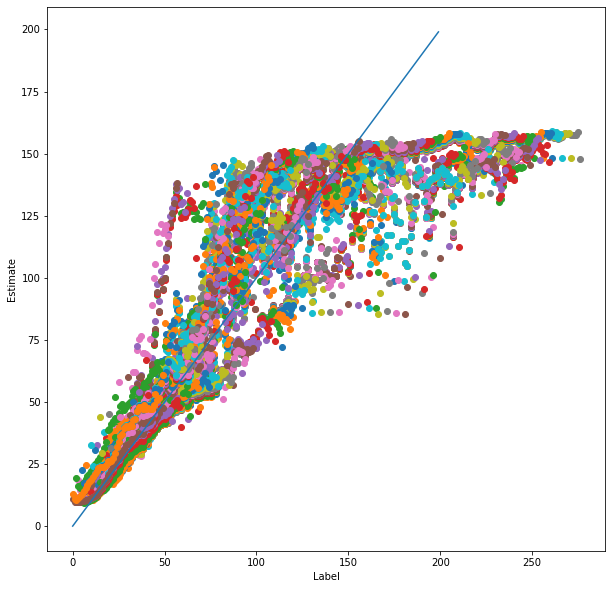

In [160]:
Yhat_train = lstm_model.predict(Xtrain_whole_sequences)
plt.figure(figsize=(10,10))
for i in range(1000):
    if i % 5 == 0:
        y1 = np.squeeze(Yhat_train[i])
        y2 = np.squeeze(Ytrain_whole_sequences[i,:,0])
        plt.scatter(y2,y1)
plt.xlabel('Label')
plt.ylabel('Estimate')
plt.plot(range(200))
plt.show()

In [80]:
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_4 (Masking)         (None, 50, 14)            0         
                                                                 
 conv1d_4 (Conv1D)           (None, 46, 32)            2272      
                                                                 
 lstm_8 (LSTM)               (None, 46, 64)            24832     
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dense_12 (Dense)            (None, 16)               

In [65]:
df1 = pd.DataFrame(columns=['A','B','C','D','E','F','G'])

In [75]:
df1 = pd.concat((df1, df))

In [76]:
df1

,A,B,C,D,E,F,G
0,1,2,3,4,5,6,7
0,1,2,3,4,5,6,7


In [50]:
Yhat_train = lstm_model.predict(Xtrain_whole_sequences)
evaluate(Ytrain_whole_sequences[:,8], Yhat_train, 'Train')
Yhat_test = lstm_model.predict(Xtest_sequences)
evaluate(Ytest_sequences, Yhat_test)

Train set RSME = 12.133970260620117, R2 = 0.9520173657205261
Test set RSME = 34.013545989990234, S = 88251.234375, R2 = 0.3300471144299555


(34.013546, 88251.234, 0.3300471144299555)

In [53]:
Yhat_train = lstm_model.predict(Xtrain_whole_sequences)
evaluate(Ytrain_whole_sequences[:,8], Yhat_train, 'Train')
Yhat_test = lstm_model.predict(Xtest_sequences)
evaluate(Ytest_sequences, Yhat_test)

Train set RSME = 15.738731384277344, R2 = 0.8805356528252978
Test set RSME = 40.799015045166016, S = 19840.470703125, R2 = 0.036082636004615476


(40.799015, 19840.47, 0.036082636004615476)

In [428]:
training_data_with_labels.df.columns

Index(['id', 'dt', 'set1', 'set2', 'set3', 's2', 's3', 's4', 's6', 's7', 's8',
       's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's19',
       's20', 's21', 'linear', 'kmeans', 'kmeans_5', 'kmeans_0', 'kmeans_2',
       'kmeans_3', 'kmeans_4', 'kmeans_1', 'piecewise_optimized',
       'piecewise_125', 'descriptive', 'spearman', 'rec_error'],
      dtype='object')

# Putting all together in one loop

In [26]:
for dataset in [2]:
    tr, te, rl = tb.getTFDataset(set = dataset)
    tb.addTFlinear(tr, te, rl)
    tr_df = rd.RUL_DataFrame(df = tr, label_cols = ['linear'])
    te_df = rd.RUL_DataFrame(df = te, label_cols = ['linear'])
    if dataset in [1,3]:
        preproc.drop_zero_variance(rul_df = tr_df, rul_df_test = te_df)
        preproc.scale(rul_df = tr_df, rul_df_test = te_df, scale = 'minmax')
    elif dataset in [2, 4]:
        classy.fit_kmeans(rul_df = tr_df, rul_df_test = te_df, colname = 'kmeans')
        preproc.one_hot_encode(rul_df = tr_df, rul_df_test = te_df, c_col = 'kmeans')
        preproc.c_drop_zero_variance(rul_df = tr_df, rul_df_test = te_df , c_cols = tr_df.categ_cols)
        preproc.c_scale(rul_df = tr_df, rul_df_test = te_df , c_cols = tr_df.categ_cols, scale = 'std')
    
    # adjust to label size
    preproc.delete_first_n(tr_df, 9)

    labels = pd.read_csv(f'labels/FD00{dataset}')
    label_cols = ['linear', 'piecewise_optimized', 'piecewise_125', 'descriptive', 'spearman', 'rec_error']
    if not labels.shape[0] == tr_df.df.shape[0]:
        print(f'Labels and Data do not have same length. Dataset FD00{dataset}')
    temp = pd.concat([tr_df.df, labels], axis=1)
    training_data_with_labels = rd.RUL_DataFrame(df = temp, data_cols = tr_df.data_cols, categ_cols = tr_df.categ_cols, label_cols = ['linear', 'piecewise_optimized', 'piecewise_125', 'descriptive', 'spearman',
                                                            'rec_error'])

    Xtrain = training_data_with_labels.df[training_data_with_labels.data_cols + training_data_with_labels.categ_cols]
    Xtest = te_df.df[te_df.data_cols + te_df.categ_cols]
    Ytrain = training_data_with_labels.df[training_data_with_labels.label_cols + training_data_with_labels.categ_cols]
    Ytest = te_df.df['linear']

    sequence_length = 60
    stride = 20
    frac = 2
    mask_value = -100.0
    groupshufflesplit = GroupShuffleSplit(n_splits = 1, train_size = 0.8 , random_state = 42)
    Xtrain_split, Ytrain_split, groupstrain, Xval_split, Yval_split, groupsval = training_validation_split(Xtrain, Ytrain, groupshufflesplit, 
                                                                                        groups = training_data_with_labels.df[training_data_with_labels.id_col])

    Xtrain_split_sequences = make_data_to_sequence(Xtrain_split, sequence_length, groupstrain, mask_value, stride, frac = frac)
    Ytrain_split_sequences = make_data_to_sequence(Ytrain_split, sequence_length, groupstrain, mask_value, stride, y = True, frac = frac)
    Xval_split_sequences = make_data_to_sequence(Xval_split, sequence_length, groupsval, mask_value, stride, frac = frac)
    Yval_split_sequences = make_data_to_sequence(Yval_split, sequence_length, groupsval, mask_value, stride, y = True, frac = frac)

    Xtrain_whole_sequences = make_data_to_sequence(Xtrain, sequence_length, tr_df.df[tr_df.id_col], mask_value, stride, frac = frac)
    Ytrain_whole_sequences = make_data_to_sequence(Ytrain, sequence_length, tr_df.df[tr_df.id_col], mask_value, stride, y = True, frac = frac)

    Xtest_sequences = make_xtest_to_sequence(Xtest, sequence_length, te_df.df[te_df.id_col], mask_value)
    Ytest_sequences = make_ytest(Ytest, sequence_length, te_df.df[te_df.id_col])

    keras.backend.clear_session()


    batch = 64
    epochs = 16
    
    for iteration in [1]:
        path = f'scores/LSTM_FD00{dataset}_{iteration}'
        results = pd.DataFrame(columns=['dataset', 'label', 'RSME_w','R2_w','RSME_tr','R2_tr', 'RSME_v','R2_v','RSME_te','S Score', 'L Score', 'R2_te'])
        for l in range(6): #'linear', 'piecewise_optimized', 'piecewise_125', 'descriptive', 'spearman', 'rec_error'
            keras.backend.clear_session()
            lstm_model = make_model(input_shape = Xtrain_split_sequences.shape[1:])
            lstm_model.fit(Xtrain_split_sequences, Ytrain_split_sequences[:,l],
                            validation_data = (Xval_split_sequences, Yval_split_sequences[:,l]),
                            epochs = epochs,
                            batch_size = batch)
            label_name = label_cols[l]
            lstm_model.save(f'saved_models/lstm_model_FD00{dataset}_{label_name}_{iteration}')

            Yhat_train = lstm_model.predict(Xtrain_whole_sequences)
            rsmewhole, r2whole = evaluate(Ytrain_whole_sequences[:,l], Yhat_train, 'Train')

            Yhat_train_split = lstm_model.predict(Xtrain_split_sequences)
            rsmesplit, r2split = evaluate(Ytrain_split_sequences[:,l], Yhat_train_split, 'Train Split')

            Yhat_val_split = lstm_model.predict(Xval_split_sequences)
            rsmeval, r2val = evaluate(Yval_split_sequences[:,l], Yhat_val_split, 'Train')

            Yhat_test = lstm_model.predict(Xtest_sequences)
            rsmetest, s, ls, r2test = evaluate(Ytest_sequences, Yhat_test)

            df = pd.DataFrame([[dataset, label_name, rsmewhole, r2whole, rsmesplit, r2split, rsmeval, r2val, rsmetest, s, ls, r2test]], columns=['dataset', 'label', 'RSME_w','R2_w','RSME_tr','R2_tr', 'RSME_v','R2_v','RSME_te','S Score', 'L Score', 'R2_te'])
            results = pd.concat((results, df))
        results.to_csv(path, index = False)

Epoch 1/16
36/36 [==============================] - 10s 200ms/step - loss: 5959.6885 - val_loss: 3426.0388
Epoch 2/16
36/36 [==============================] - 6s 172ms/step - loss: 3338.9626 - val_loss: 2316.7590
Epoch 3/16
36/36 [==============================] - 8s 214ms/step - loss: 3066.5710 - val_loss: 2299.1738
Epoch 4/16
36/36 [==============================] - 8s 217ms/step - loss: 3019.8645 - val_loss: 2215.6335
Epoch 5/16
36/36 [==============================] - 8s 220ms/step - loss: 2830.2661 - val_loss: 1601.8760
Epoch 6/16
36/36 [==============================] - 9s 249ms/step - loss: 1682.2068 - val_loss: 815.2674
Epoch 7/16
36/36 [==============================] - 9s 250ms/step - loss: 1295.4644 - val_loss: 625.1860
Epoch 8/16
36/36 [==============================] - 8s 230ms/step - loss: 1174.3717 - val_loss: 585.8012
Epoch 9/16
36/36 [==============================] - 8s 226ms/step - loss: 1135.4811 - val_loss: 526.9388
Epoch 10/16
36/36 [==============================

INFO:tensorflow:Assets written to: saved_models/lstm_model_FD002_linear_1\assets


INFO:tensorflow:Assets written to: saved_models/lstm_model_FD002_linear_1\assets


Train set RSME = 23.66413688659668, R2 = 0.7915955934461667
Train Split set RSME = 23.82979965209961, R2 = 0.7952546628438202
Train set RSME = 22.950510025024414, R2 = 0.7715080892288018
Test set RSME = 64.53764343261719, S = 785496.3125, L= 5789.57568359375, R2 = -0.4401382293510958
Epoch 1/16
36/36 [==============================] - 11s 213ms/step - loss: 4743.9956 - val_loss: 2766.7329
Epoch 2/16
36/36 [==============================] - 7s 197ms/step - loss: 2513.0488 - val_loss: 1800.3899
Epoch 3/16
36/36 [==============================] - 7s 194ms/step - loss: 2254.6907 - val_loss: 1770.0088
Epoch 4/16
36/36 [==============================] - 8s 223ms/step - loss: 2186.9336 - val_loss: 1771.9692
Epoch 5/16
36/36 [==============================] - 10s 283ms/step - loss: 2207.8130 - val_loss: 1768.4518
Epoch 6/16
36/36 [==============================] - 9s 240ms/step - loss: 2183.8435 - val_loss: 1768.0133
Epoch 7/16
36/36 [==============================] - 8s 215ms/step - loss: 211

INFO:tensorflow:Assets written to: saved_models/lstm_model_FD002_piecewise_optimized_1\assets


INFO:tensorflow:Assets written to: saved_models/lstm_model_FD002_piecewise_optimized_1\assets


Train set RSME = 20.23094367980957, R2 = 0.7928626472581337
Train Split set RSME = 20.271892547607422, R2 = 0.7967751282746678
Train set RSME = 20.056882858276367, R2 = 0.7726675138122456
Test set RSME = 57.308074951171875, S = 584997.25, L= 4417.9599609375, R2 = -0.1355584903133049
Epoch 1/16
36/36 [==============================] - 13s 293ms/step - loss: 4579.9487 - val_loss: 3059.6035
Epoch 2/16
36/36 [==============================] - 11s 293ms/step - loss: 2550.9695 - val_loss: 1501.1890
Epoch 3/16
36/36 [==============================] - 10s 271ms/step - loss: 1957.9933 - val_loss: 1486.1158
Epoch 4/16
36/36 [==============================] - 11s 302ms/step - loss: 1919.5145 - val_loss: 1484.0463
Epoch 5/16
36/36 [==============================] - 11s 291ms/step - loss: 1827.9209 - val_loss: 1485.1465
Epoch 6/16
36/36 [==============================] - 10s 269ms/step - loss: 1851.6097 - val_loss: 1484.3463
Epoch 7/16
36/36 [==============================] - 11s 310ms/step - loss:

INFO:tensorflow:Assets written to: saved_models/lstm_model_FD002_piecewise_125_1\assets


INFO:tensorflow:Assets written to: saved_models/lstm_model_FD002_piecewise_125_1\assets


Train set RSME = 14.075142860412598, R2 = 0.8754023184089479
Train Split set RSME = 14.129023551940918, R2 = 0.876294168906675
Train set RSME = 13.845016479492188, R2 = 0.870802430229864
Test set RSME = 57.26851272583008, S = 1229391.875, L= 4005.830810546875, R2 = -0.13399126460762223
Epoch 1/16
36/36 [==============================] - 12s 270ms/step - loss: 5581.9492 - val_loss: 2855.1731
Epoch 2/16
36/36 [==============================] - 10s 279ms/step - loss: 2665.8359 - val_loss: 2072.3406
Epoch 3/16
36/36 [==============================] - 9s 259ms/step - loss: 2565.2161 - val_loss: 2057.7092
Epoch 4/16
36/36 [==============================] - 11s 302ms/step - loss: 2555.3027 - val_loss: 2061.9539
Epoch 5/16
36/36 [==============================] - 10s 289ms/step - loss: 2555.8618 - val_loss: 2059.9497
Epoch 6/16
36/36 [==============================] - 10s 269ms/step - loss: 2525.3921 - val_loss: 2057.4819
Epoch 7/16
36/36 [==============================] - 9s 249ms/step - loss

INFO:tensorflow:Assets written to: saved_models/lstm_model_FD002_descriptive_1\assets


INFO:tensorflow:Assets written to: saved_models/lstm_model_FD002_descriptive_1\assets


Train set RSME = 30.532236099243164, R2 = 0.5838621958010091
Train Split set RSME = 30.849246978759766, R2 = 0.582963210643302
Train set RSME = 29.15386390686035, R2 = 0.5868331513039668
Test set RSME = 59.29316711425781, S = 513829.53125, L= 5067.89013671875, R2 = -0.21559021701218795
Epoch 1/16
36/36 [==============================] - 11s 204ms/step - loss: 5194.1382 - val_loss: 2501.2639
Epoch 2/16
36/36 [==============================] - 7s 202ms/step - loss: 2229.3740 - val_loss: 1660.0002
Epoch 3/16
36/36 [==============================] - 7s 192ms/step - loss: 2088.2510 - val_loss: 1649.0038
Epoch 4/16
36/36 [==============================] - 7s 191ms/step - loss: 2092.7993 - val_loss: 1654.5521
Epoch 5/16
36/36 [==============================] - 7s 191ms/step - loss: 2072.3936 - val_loss: 1648.0496
Epoch 6/16
36/36 [==============================] - 7s 192ms/step - loss: 2061.7595 - val_loss: 1640.3370
Epoch 7/16
36/36 [==============================] - 7s 191ms/step - loss: 19

INFO:tensorflow:Assets written to: saved_models/lstm_model_FD002_spearman_1\assets


INFO:tensorflow:Assets written to: saved_models/lstm_model_FD002_spearman_1\assets


Train set RSME = 28.092458724975586, R2 = 0.5611243379263424
Train Split set RSME = 28.19980239868164, R2 = 0.5662471109576767
Train set RSME = 27.634016036987305, R2 = 0.5352102648023285
Test set RSME = 58.67020797729492, S = 850705.3125, L= 4666.90673828125, R2 = -0.19018117236626075
Epoch 1/16
36/36 [==============================] - 12s 264ms/step - loss: 10052.8076 - val_loss: 7239.1694
Epoch 2/16
36/36 [==============================] - 9s 255ms/step - loss: 4863.6426 - val_loss: 2087.1174
Epoch 3/16
36/36 [==============================] - 9s 258ms/step - loss: 2491.5308 - val_loss: 1905.3325
Epoch 4/16
36/36 [==============================] - 9s 257ms/step - loss: 2401.7625 - val_loss: 1907.9551
Epoch 5/16
36/36 [==============================] - 9s 263ms/step - loss: 2427.4866 - val_loss: 1907.4482
Epoch 6/16
36/36 [==============================] - 9s 256ms/step - loss: 2331.2744 - val_loss: 1906.3760
Epoch 7/16
36/36 [==============================] - 9s 254ms/step - loss: 2

INFO:tensorflow:Assets written to: saved_models/lstm_model_FD002_rec_error_1\assets


INFO:tensorflow:Assets written to: saved_models/lstm_model_FD002_rec_error_1\assets


Train set RSME = 30.57546043395996, R2 = 0.5201332513421342
Train Split set RSME = 30.37577247619629, R2 = 0.5286055138689856
Train set RSME = 31.40570831298828, R2 = 0.48214690549552075
Test set RSME = 56.15243911743164, S = 750265.6875, L= 4207.10302734375, R2 = -0.09022260510370361


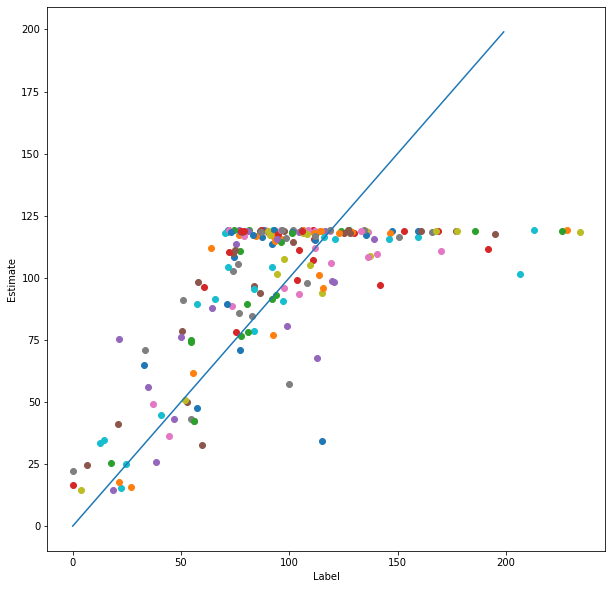

In [35]:
plt.figure(figsize=(10,10))
for i in range(1000):
    if i % 5 == 0:
        y1 = np.squeeze(Yhat_train[i])
        y2 = np.squeeze(Ytrain_whole_sequences[i,5])
        plt.scatter(y2,y1)
plt.xlabel('Label')
plt.ylabel('Estimate')
plt.plot(range(200))
plt.show()

In [530]:
lstm_model = make_model(input_shape = Xtrain_split_sequences.shape[1:], masking = True, mask_value = -100., conv_layer = False, n_channels = 32, kernel_size = 10,
                regularization = None, lstm_dims = [256], dropout = True, d_rate = 0.1, dense_dims =  [])

In [36]:
path = f'scores/LSTM_FD00{3}_{1}'
results = pd.read_csv(path)

In [30]:
results

,dataset,label,RSME_w,R2_w,RSME_tr,R2_tr,RSME_v,R2_v,RSME_te,S Score,L Score,R2_te
0,3,linear,46.290234,0.696437,46.750790,0.700140,44.280918,0.674165,45.856323,1.579231e+06,1301.146118,-0.227127
1,3,piecewise_optimized,37.111198,0.646383,36.551128,0.654335,39.401173,0.612508,27.771736,2.904259e+03,575.354858,0.549912
2,3,piecewise_125,17.777119,0.831460,17.761562,0.833048,17.843035,0.823583,20.299397,8.923704e+02,331.563751,0.759532
3,3,descriptive,47.333920,0.580988,45.780727,0.595184,53.429543,0.529364,44.575455,2.120517e+04,1666.530151,-0.159532
4,3,spearman,42.572960,0.489691,41.563389,0.499367,46.617596,0.453701,29.758593,3.303979e+03,957.557800,0.483208
5,3,rec_error,47.512245,0.430091,45.693241,0.447943,54.566013,0.368604,62.467270,4.745548e+04,4988.858398,-1.277174


In [37]:
from tabulate import tabulate
print(tabulate(results[['label', 'RSME_w', 'RSME_tr','RSME_v', 'RSME_te', 'S Score', 'L Score']], headers=['Label','RSME Whole','RSME Training','RSME Validation', 'RSME Testing', 'S', 'L'], tablefmt='latex', showindex=False))

\begin{tabular}{lrrrrrr}
\hline
 Label               &   RSME Whole &   RSME Training &   RSME Validation &   RSME Testing &               S &        L \\
\hline
 linear              &      46.2902 &         46.7508 &           44.2809 &        45.8563 &     1.57923e+06 & 1301.15  \\
 piecewise\_optimized &      37.1112 &         36.5511 &           39.4012 &        27.7717 &  2904.26        &  575.355 \\
 piecewise\_125       &      17.7771 &         17.7616 &           17.843  &        20.2994 &   892.37        &  331.564 \\
 descriptive         &      47.3339 &         45.7807 &           53.4295 &        44.5755 & 21205.2         & 1666.53  \\
 spearman            &      42.573  &         41.5634 &           46.6176 &        29.7586 &  3303.98        &  957.558 \\
 rec\_error           &      47.5122 &         45.6932 &           54.566  &        62.4673 & 47455.5         & 4988.86  \\
\hline
\end{tabular}


In [7]:
new_model = tf.keras.models.load_model(f'saved_models/lstm_model_FD00{1}_linear_{1}')


In [ ]:
for dataset in [2,4]:
    tr, te, rl = tb.getTFDataset(set = dataset)
    tb.addTFlinear(tr, te, rl)
    tr_df = rd.RUL_DataFrame(df = tr, label_cols = ['linear'])
    te_df = rd.RUL_DataFrame(df = te, label_cols = ['linear'])
    if dataset in [1,3]:
        preproc.drop_zero_variance(rul_df = tr_df, rul_df_test = te_df)
        preproc.scale(rul_df = tr_df, rul_df_test = te_df, scale = 'minmax')
    elif dataset in [2, 4]:
        classy.fit_kmeans(rul_df = tr_df, rul_df_test = te_df, colname = 'kmeans')
        preproc.one_hot_encode(rul_df = tr_df, rul_df_test = te_df, c_col = 'kmeans')
        preproc.c_drop_zero_variance(rul_df = tr_df, rul_df_test = te_df , c_cols = tr_df.categ_cols)
        preproc.c_scale(rul_df = tr_df, rul_df_test = te_df , c_cols = tr_df.categ_cols, scale = 'std')
    
    # adjust to label size
    preproc.delete_first_n(tr_df, 9)

    labels = pd.read_csv(f'labels/FD00{dataset}')
    label_cols = ['linear', 'piecewise_optimized', 'piecewise_125', 'descriptive', 'spearman', 'rec_error']
    if not labels.shape[0] == tr_df.df.shape[0]:
        print(f'Labels and Data do not have same length. Dataset FD00{dataset}')
    temp = pd.concat([tr_df.df, labels], axis=1)
    training_data_with_labels = rd.RUL_DataFrame(df = temp, data_cols = tr_df.data_cols, categ_cols = tr_df.categ_cols, label_cols = ['linear', 'piecewise_optimized', 'piecewise_125', 'descriptive', 'spearman',
                                                            'rec_error'])

    Xtrain = training_data_with_labels.df[training_data_with_labels.data_cols + training_data_with_labels.categ_cols]
    Xtest = te_df.df[te_df.data_cols + te_df.categ_cols]
    Ytrain = training_data_with_labels.df[training_data_with_labels.label_cols + training_data_with_labels.categ_cols]
    Ytest = te_df.df['linear']

    sequence_length = 60
    stride = 20
    frac = 2
    mask_value = -100.0
    groupshufflesplit = GroupShuffleSplit(n_splits = 1, train_size = 0.8 , random_state = 42)
    Xtrain_split, Ytrain_split, groupstrain, Xval_split, Yval_split, groupsval = training_validation_split(Xtrain, Ytrain, groupshufflesplit, 
                                                                                        groups = training_data_with_labels.df[training_data_with_labels.id_col])

    Xtrain_split_sequences = make_data_to_sequence(Xtrain_split, sequence_length, groupstrain, mask_value, stride, frac = frac)
    Ytrain_split_sequences = make_data_to_sequence(Ytrain_split, sequence_length, groupstrain, mask_value, stride, y = True, frac = frac)
    Xval_split_sequences = make_data_to_sequence(Xval_split, sequence_length, groupsval, mask_value, stride, frac = frac)
    Yval_split_sequences = make_data_to_sequence(Yval_split, sequence_length, groupsval, mask_value, stride, y = True, frac = frac)

    Xtrain_whole_sequences = make_data_to_sequence(Xtrain, sequence_length, tr_df.df[tr_df.id_col], mask_value, stride, frac = frac)
    Ytrain_whole_sequences = make_data_to_sequence(Ytrain, sequence_length, tr_df.df[tr_df.id_col], mask_value, stride, y = True, frac = frac)

    Xtest_sequences = make_xtest_to_sequence(Xtest, sequence_length, te_df.df[te_df.id_col], mask_value)
    Ytest_sequences = make_ytest(Ytest, sequence_length, te_df.df[te_df.id_col])

# Fit linear model for comparison

In [167]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(Xtrain, Ytrain['rec_error'])

Yhat_lm_test = lm.predict(Xtest_sequences)
evaluate(Ytest, Yhat_lm_test)

Test set RSME = 55.14430606680672, S = 19759454077.306793 R2 = 0.07999694871695906


,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,0.298494,0.363462,0.313808,0.683736,0.225758,0.124877,0.251190,0.736887,0.241176,0.166622,0.321239,0.316667,0.654264,0.684065
1,0.312349,0.346130,0.313876,0.686634,0.224242,0.126411,0.232143,0.731343,0.239706,0.167633,0.326818,0.316667,0.644961,0.692309
2,0.309639,0.327796,0.308828,0.699034,0.231818,0.128789,0.213690,0.721109,0.232353,0.169058,0.312197,0.308333,0.649612,0.684355
3,0.331325,0.315152,0.303140,0.685829,0.237879,0.126043,0.220238,0.708955,0.239706,0.166410,0.311197,0.333333,0.648062,0.674896
4,0.331325,0.337301,0.298565,0.686312,0.234848,0.125096,0.238690,0.683582,0.227941,0.166720,0.322047,0.341667,0.671318,0.676098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19726,0.676506,0.623174,0.739855,0.261997,0.490909,0.202697,0.753571,0.245203,0.525000,0.212767,0.713390,0.666667,0.242636,0.273875
19727,0.673795,0.639612,0.760263,0.251208,0.492424,0.202324,0.753571,0.235181,0.525000,0.210708,0.715391,0.658333,0.213953,0.264015
19728,0.680723,0.649836,0.762981,0.253945,0.489394,0.201526,0.741667,0.235821,0.529412,0.211281,0.747403,0.683333,0.220155,0.247183
19729,0.666867,0.661631,0.768687,0.238969,0.500000,0.203334,0.765476,0.239446,0.527941,0.211028,0.767372,0.666667,0.192248,0.247860


In [254]:
# prepare data
# 1. training-validation split

def training_validation_split(X, Y, groupshufflesplit, groups = tr_df.df[tr_df.id_col], verbose = False):
    for itrain, ival in groupshufflesplit.split(X, Y, groups = groups):
        Xtrain = X.iloc[itrain].copy()
        Ytrain = Y.iloc[itrain].copy()
        Xval = X.iloc[ival].copy()
        Yval = Y.iloc[ival].copy()
        if verbose:
            print(f'Training data ids {groups[itrain].unique()}')
            print(f'Validation data ids {groups[ival].unique()}')
    return Xtrain, Ytrain, groups[itrain], Xval, Yval, groups[ival]

# 2. make xtest
def make_xtest_to_sequences_one_id(df, sequence_length, mask_value):
    n = df.shape[0]
    if n > sequence_length:
        return df[sequence_length-1:n]
    if n < sequence_length:
        index = sequence_length - n
        Xpadded = np.full(shape = (sequence_length, df.shape[1]), fill_value = mask_value).astype(np.float32)
        Xpadded[index:, :] = df.values
        yield Xpadded
def make_xtest_to_sequences(df, sequence_length, groups, mask_value):
    Xtemp = (list(make_xtest_to_sequences_one_id(df[groups==i], sequence_length, mask_value)) for i in groups.unique())
    return np.concatenate(list(Xtemp)).astype(np.float32)

# 3. make ytest
def make_ytest_one_id(df, sequence_length):
    return df[-1:]   
def make_ytest(df, sequence_length, groups):
    Ytemp = [make_ytest_one_id(df[groups==i], sequence_length) for i in groups.unique()]
    return np.concatenate(Ytemp).astype(np.float32)

# 4. make xrain data
def make_xtrain_to_sequences_one_id(df, sequence_length, mask_value):
    n = df.shape[0]
    if n > sequence_length:
        for start, stop in zip(range(0, n - sequence_length + 1), range(sequence_length, n + 1)):
            yield(df.values[start:stop,:])
    if n < sequence_length:
        index = sequence_length - n
        Xpadded = np.full(shape = (sequence_length, df.shape[1]), fill_value = mask_value).astype(np.float32)
        Xpadded[index:, :] = df.values
        yield Xpadded
def make_xtrain_to_sequence(df, sequence_length, groups, mask_value):
    Xtemp = (list(make_xtrain_to_sequences_one_id(df[groups==i], sequence_length, mask_value)) for i in groups.unique())
    return np.concatenate(list(Xtemp)).astype(np.float32)
# 5. make ytrain data
def make_ytrain_accordingly_one_id(df, sequence_length, mask_value):
    n = df.shape[0]
    if n < sequence_length:
        return df[-1:]
    return df[sequence_length-1:n] 
def make_ytrain_accordingly(df, sequence_length, groups, mask_value):
    Ytemp = [make_ytrain_accordingly_one_id(df[groups==i], sequence_length, mask_value) for i in groups.unique()]
    return np.concatenate(Ytemp).astype(np.float32)

In [255]:
sequence_length = 100
mask_value = 100.0
groupshufflesplit = GroupShuffleSplit(n_splits = 1, train_size = 0.8 , random_state = 42)
Xtrain_split, Ytrain_split, groupstrain, Xval_split, Yval_split, groupsval = training_validation_split(Xtrain, Ytrain, groupshufflesplit)
Xtrain_split_sequences = make_x_to_sequences(Xtrain_split, sequence_length, groupstrain)
Ytrain_split_sequences = make_y_accordingly(Ytrain_split, sequence_length, groupstrain)
Xval_split_sequences = make_x_to_sequences(Xval_split, sequence_length, groupsval)
Yval_split_sequences = make_y_accordingly(Xval_split, sequence_length, groupsval)

Xtrain_whole_sequences = make_x_to_sequences(Xtrain, sequence_length, tr_df.df[tr_df.id_col])
Ytrain_whole_sequences = make_y_accordingly(Ytrain, sequence_length, tr_df.df[tr_df.id_col])

Xtest_sequences = make_test_x_to_sequence(Xtest, sequence_length, te_df.df[te_df.id_col], mask_value)
Ytest_sequences = make_test_y_accordingly(Ytest, sequence_length, te_df.df[te_df.id_col], mask_value)

### LSTM Model
Layers:
1. 1D Convolutional Layer (input_dim) -> 32
2. LSTM 32 -> 256
3. LSTM 246 -> 128
4. Dense 128 -> 128
5. Dense 128 -> 16
6. Dense 16 -> 1

In [ ]:
def make_model(input_shape = Xtrain_split_sequences.shape[1:], masking = True, mask_value = 100., conv_layer = True, n_channels = 32, kernel_size = 5,
                dense_regulatization = regularizers.l2(0.001), lstm_regularization = regularizers.l2(0.001), conv_regualrizer = regularizers.l2(0.001),
                lstm_dims = [256, 128], dropout = True, d_rate = 0.2, dense_dims = [128, 16]):
    model = Sequential()
    if masking:
        model.add(Masking(mask_value = mask_value, input_shape = input_shape))
    if conv_layer:
        model.add(Conv1D(filters = n_channels, kernel_size = kernel_size, activation = 'relu', kernel_regularizer = conv_regualrizer))
    rs = True
    n = len(lstm_dims)
    c = 1
    for d in lstm_dims:
        if c == n:
            rs = False
        model.add(LSTM(units = d, return_sequences = rs, kernel_regularizer = lstm_regularization))
        c += 1
    if dropout:
        model.add(Dropout(rate = d_rate))
    for d in dense_dims:
        model.add(Dense(units = d, activation = 'relu', kernel_regularizer = dense_regulatization))
    model.add(Dense(units = 1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
lstm_model = make_model()
lstm_model.fit(Xtrain_split_sequences, Ytrain_split_sequences[:,3],
                    validation_data = (Xval_split_sequences, Yval_split_sequences[:,3]),
                    epochs = 50,
                    batch_size = 2) 

In [136]:
Yhat_train = lstm_model.predict(Xtrain_whole_sequences)
evaluate(Ytrain_whole_sequences[:,3], Yhat_train, 'Train')
Yhat_test = lstm_model.predict(Xtest_sequences)
evaluate(Ytest_sequences, Yhat_test)

Test set RSME = 36.04899215698242 and R2 = 0.24746498636972647


In [175]:
evaluate(Ytest_sequences, Yhat_test)

Test set RSME = 36.04899215698242, S = 95396.484375 R2 = 0.24746498636972647


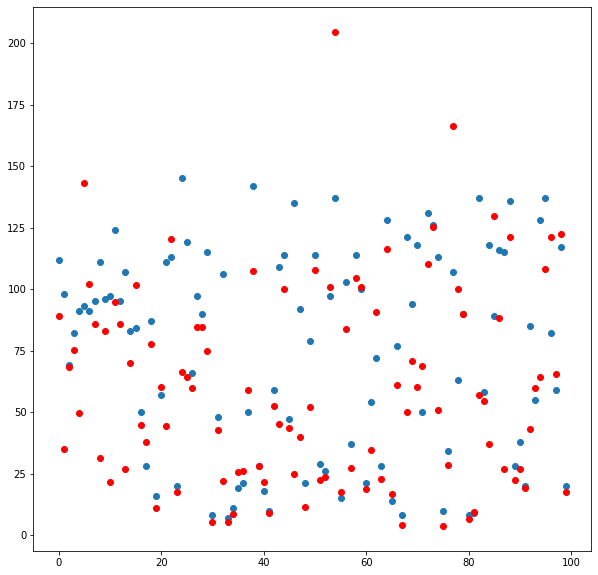

In [160]:
plt.figure(figsize = (10,10))
plt.scatter(range(len(Ytest_sequences)), Ytest_sequences)
plt.scatter(range(len(Yhat_test)), Yhat_test, color = 'red')
plt.show()

In [132]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_2 (Masking)         (None, 100, 14)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 32)            2272      
                                                                 
 lstm_4 (LSTM)               (None, 96, 256)           295936    
                                                                 
 lstm_5 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 16)               

In [ ]:
lstm_model.save(f'saved_models/lstm_model_FD00{dataset}_weights')